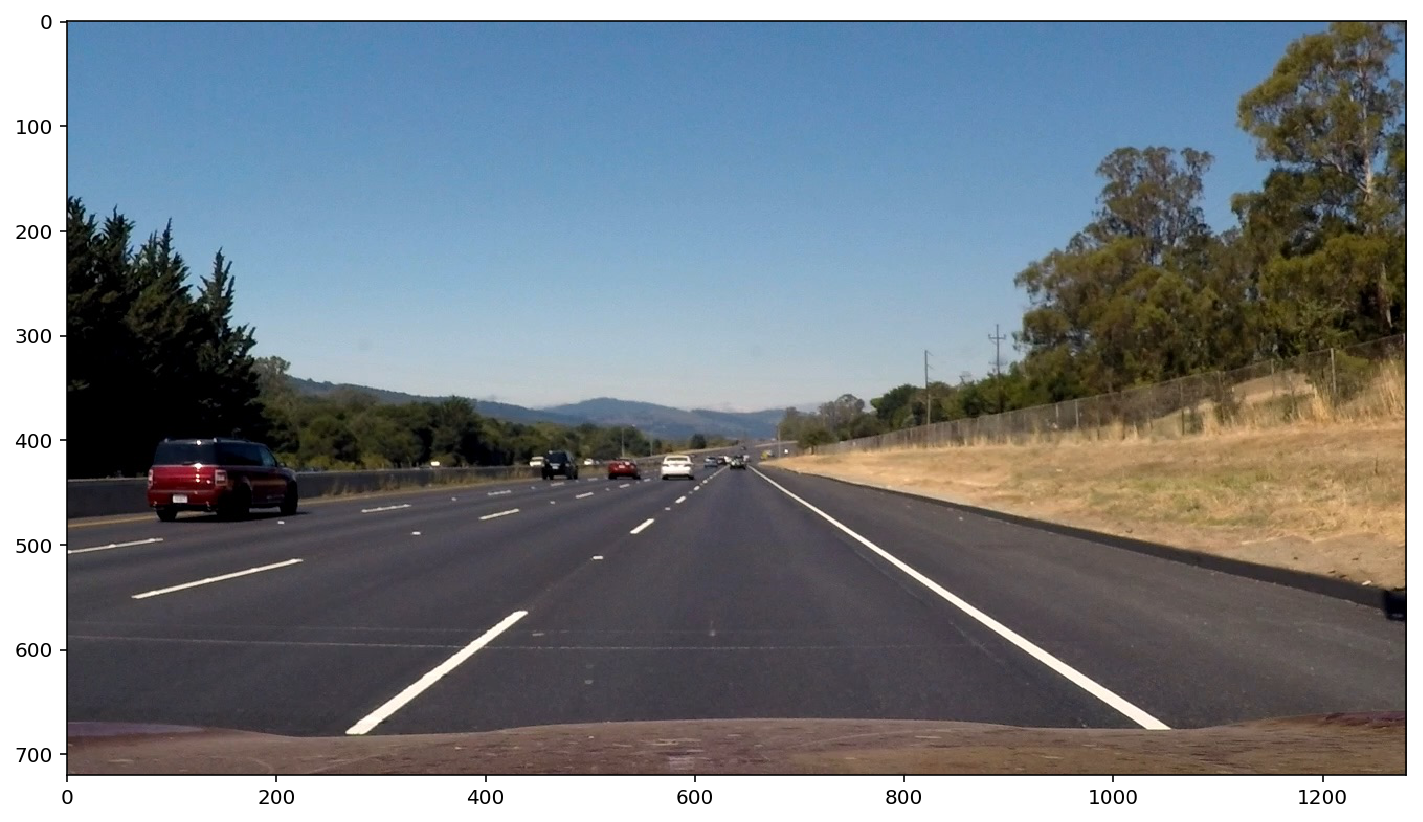

In [21]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def component():
  return random.randint(0,255)

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    
    for bbox in bboxes:
        (x1, y1), (x2, y2) = bbox
        cv2.rectangle(draw_img, (x1, y1), (x2, y2), (component(),component(),component()), thick)
    
    
    # draw each bounding box on your image copy using cv2.rectangle()
    # return the image copy with boxes drawn
    return draw_img # Change this line to return image copy with boxes

image = mpimg.imread('test_images/straight_lines2.jpg')

plt.figure(figsize=(12,12))
plt.imshow(image)

46
4


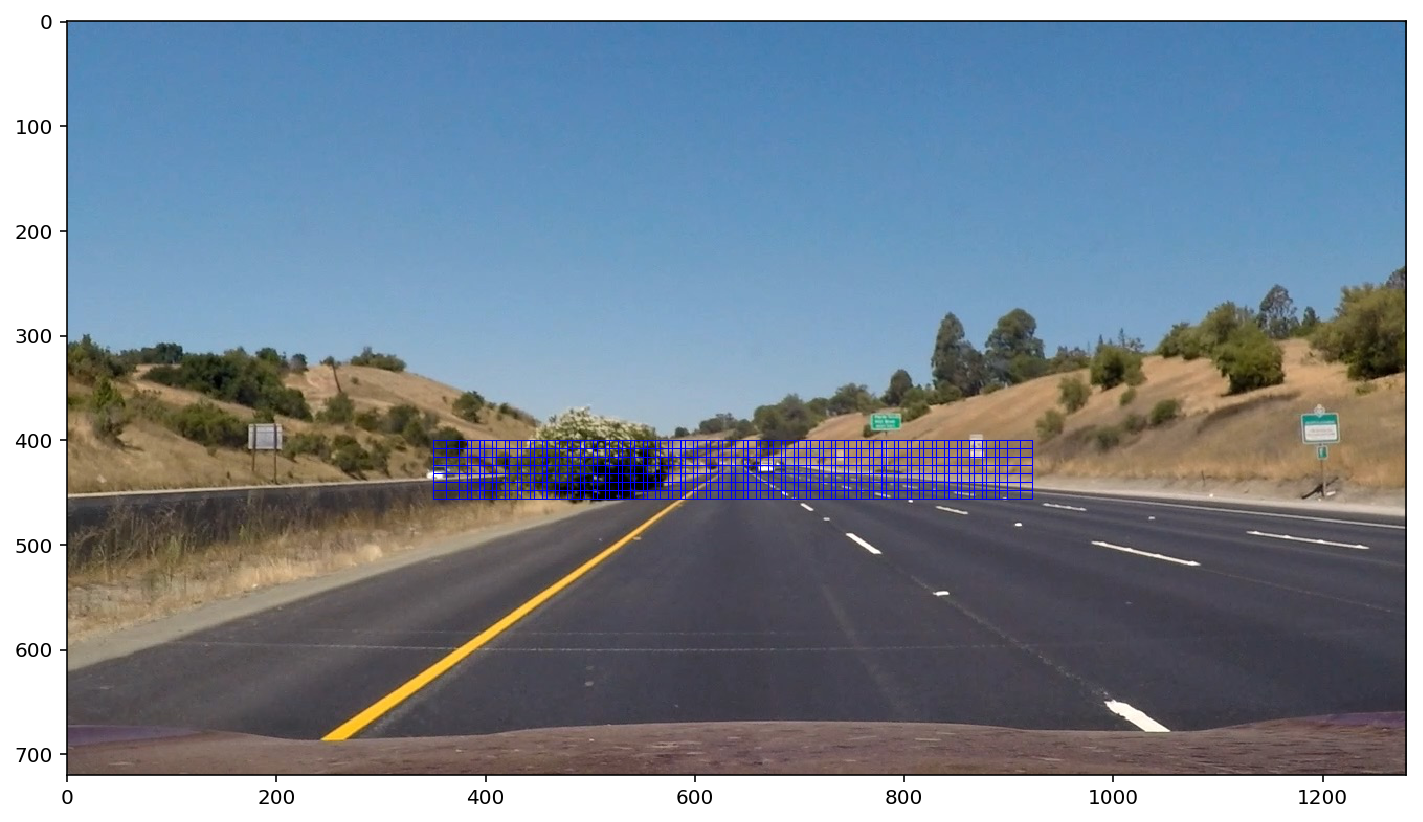

In [133]:
from skimage.feature import hog

def component():
  return random.randint(0,255)


def draw_boxes(img, bboxes, color=(0, 0, 255), thick=1):
    # make a copy of the image
    draw_img = np.copy(img)
    
    for bbox in bboxes:
        (x1, y1), (x2, y2) = bbox
        #color = (component(),component(),component())
        cv2.rectangle(draw_img, (x1, y1), (x2, y2), color, thick)
    
    
    # draw each bounding box on your image copy using cv2.rectangle()
    # return the image copy with boxes drawn
    return draw_img # Change this line to return image copy with boxes


def convert_color(img, color_space='RGB', size=(32, 32)):
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img) 
        
    return feature_image

def convert_scale(image,scale):
    height,width = np.int(image.shape[0]/scale), np.int(image.shape[1]/scale)
    image = cv2.resize(image,(width,height))
    return image

def get_hog_features(
        img, 
        orientations, 
        pix_per_cell, 
        cell_per_block):
    
    results = []
    
    channels = img.shape[2]
    
    for channel in range(channels):
        
        image = img[:,:,channel]
 
        features = hog(
            image, 
            orientations=orientations,
            pixels_per_cell=(pix_per_cell, pix_per_cell), 
            cells_per_block=(cell_per_block, cell_per_block), 
            visualise=False, 
            feature_vector=False,
            block_norm="L2-Hys",
            transform_sqrt = False)
        
        results.append(features)
        
    return np.stack(results,axis=-1)
        

def hog_sliding_windows(
        img,
        x_range,
        y_range,
        scale,
        cell_per_step):
    
    orientations = 9
    pix_per_cell = 8
    cell_per_block = 2
    
    window = 4 * cell_per_block * pix_per_cell
    
    cell_per_step_x, cell_per_step_y = cell_per_step
    
    x_start,x_stop = x_range
    y_start,y_stop = y_range
    
    image = np.copy(img)
    image = img[y_start:y_stop,x_start:x_stop,:]
    image = convert_scale(image,scale)
    
    height,width,_ = image.shape
    
    hog_features = get_hog_features(
        image,
        orientations, 
        pix_per_cell, 
        cell_per_block)
    
    nxblocks = (width // pix_per_cell) - cell_per_block + 1
    nyblocks = (height // pix_per_cell) - cell_per_block + 1 
    
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1

    
    nxsteps = (nxblocks - nblocks_per_window + 1) // cell_per_step_x
    nysteps = (nyblocks - nblocks_per_window + 1) // cell_per_step_y
    
    print(nxsteps)
    print(nysteps)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            ypos = yb * cell_per_step_y
            xpos = xb * cell_per_step_x
        
            features = hog_features[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window]
            
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            #should not need to resize
            subimg = cv2.resize(image[ytop:ytop+window, xleft:xleft+window], (64,64))
            
     
            xbox_left = np.int(xleft * scale) + x_start
            ybox_top = np.int(ytop * scale) + y_start
            box_width = np.int(window * scale)
            
    
            box = ((xbox_left, ybox_top),(xbox_left + box_width, ybox_top + box_width))
            
            yield box,subimg,features
    
image = mpimg.imread('test_images/straight_lines1.jpg')

windows = hog_sliding_windows(image,(350,930),(400,460),0.5,cell_per_step=(3,2))

bboxes = [box for box, _, _ in windows]

#print(bboxes)
result = draw_boxes(image, bboxes)
plt.figure(figsize=(12,12))
plt.imshow(result)
            
          
    
    
    
    
    
    
    
